<a href="https://colab.research.google.com/github/jrchac/Thesis-Project-Feele/blob/main/G2020_ML_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Techniques

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series, to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

In [ ]:
%run CleaningData.ipynb   #this is were my functions are stored

#pip install tslearn
data = cleaning() #it takes long to execute (4min30s)

## Function Description



(AI-generated descriptions for the code)

1. **Data Filtering Function (`filter_by_days`)**
   - **Purpose:** To filter and organize the data based on the number of consecutive days or entries.
   - **Output:** A DataFrame containing filtered data according to the specified criteria.

2. **User ID Expansion (`expand_user_id`)**
   - **Purpose:** To modify the `user_id` such that each instance within the same user group is unique.
   - **Output:** A DataFrame with expanded `user_id` ensuring uniqueness.

3. **Pivot DataFrame (`pivot_dataframe`)**
   - **Purpose:** To reshape the DataFrame into a format suitable for clustering.
   - **Output:** A pivoted DataFrame ready for clustering.

4. **Prepare Data for Clustering (`prepare_X`)**
   - **Purpose:** To encode categorical variables and scale numerical features for clustering.
   - **Output:** A scaled and encoded DataFrame for clustering.

5. **Prepare Data for Time Series Clustering (`prepare_Z`)**
   - **Purpose:** To encode categorical variables and scale numerical features specifically for time series clustering.
   - **Output:** A scaled and encoded DataFrame for time series clustering.

6. **KMeans Clustering (`train_KMeans`)**
   - **Purpose:** To train a KMeans clustering model.
   - **Output:** A trained KMeans model.

7. **Generate Text for Word Clouds (`get_text`)**
   - **Purpose:** To extract and format text data from a DataFrame for word cloud generation.
   - **Output:** A concatenated string of text suitable for word cloud generation.

8. **Word Cloud Generation (`create_word_clouds`)**
   - **Purpose:** To generate word clouds for visualizing cluster characteristics.
   - **Output:** Displays word cloud plots.

9. **Regular KMeans Clustering (`regular_Kmeans`)**
   - **Purpose:** To apply regular KMeans clustering to the pivoted data.
   - **Output:** A tuple containing the KMeans model and a DataFrame with cluster labels.

10. **Time Series KMeans Clustering (`tsKmeans`)**
    - **Purpose:** To apply TimeSeriesKMeans clustering to time series data.
    - **Output:** A tuple containing the TimeSeriesKMeans model and a DataFrame with cluster labels.

11. **Cluster Visualization (`print_clouds`)**
    - **Purpose:** To print word clouds for the first 4 clusters.
    - **Output:** Displays word cloud plots for the first four clusters.

## Clustering - Functions

In [ ]:
def filter_by_days(data, num_days, daily, entry):
    """
    Takes dataframe and number_of_days and
    returns shifted-last-x-entries or shifted-x-daily-consecutive-entries
    Following is other varieties that function can return

    daily is True, if you are looking for consecutive days
    entry is True, if you are looking for consecutive entries


    Daily Entry Return
    True  True  Consecutive Entries without a gap in days
    True  False Last Entries of consecutive days
    False True  Consecutive Entries
    False False Only Last Entry in any day
    """



    # Group the data by user_id
    grouped_data = data.groupby('user_id')

    # List to store filtered data
    filtered_rows = []

    # Iterate over each group
    for user_id, group in grouped_data:
        # Sort the responses by date in descending order
        group = group.sort_values(by='Date', ascending=False)

        # Initialize variables for consecutive days count and consecutive rows
        consecutive_days = 0
        consecutive_rows = []
        prev_date = None

        # Iterate over each row in the group
        for _, row in group.iterrows():
            # consecutive days and only last entry of day
            if daily and not entry and (prev_date is not None) and ((prev_date - row['Date']).days == 1):
                consecutive_rows.append(row)
            # consecutive days and all entries of day
            elif daily and entry and (prev_date is not None) and ((prev_date - row['Date']).days <= 1) :
                consecutive_rows.append(row)
            # last entry of any day
            elif not daily and not entry and (prev_date is not None) and ((prev_date - row['Date']).days >= 1):
                consecutive_rows.append(row)
            # all entries of any day
            elif not daily and entry and (prev_date is not None):
                consecutive_rows.append(row)

            if ((prev_date is not None) and daily and ((prev_date - row['Date']).days > 1)) or (prev_date is None):
                # avoid gaps between days
                consecutive_rows = [row]

            if len(consecutive_rows) == num_days:
                # to change the direction of time
                filtered_rows.extend(consecutive_rows[::-1])
                # for oversampling
                consecutive_rows.pop(0)

            prev_date = row['Date']

    # Create DataFrame from filtered rows
    filtered_data = pd.DataFrame(filtered_rows).reset_index()

    return filtered_data

def expand_user_id(df, num_days):
    '''
    Since some functions uses groupby user_id and df has same user_id
    for every num_days instances, we have to create different user_id
    for every instance
    '''
    dt = df.copy()
    for i in range(dt.shape[0]):
        dt.loc[i, 'user_id'] = str(i// num_days)+ '_' + str(dt.loc[i, 'user_id'])
    return dt


def pivot_dataframe(df, num_days):
    dt = df.copy()
    dt['Day'] = dt.index % num_days
    dt = expand_user_id(dt, num_days)

    index_cols = ['user_id', 'gender', 'birthday']
    columns_col = 'Day'
    values_cols = [ 'response_age', 'question_1', 'question_2', 'question_3', 'question_4', 'question_5', 'daily_steps']

    # Assuming your data is in a DataFrame called 'df'
    pivoted_df = dt.pivot(index=index_cols, columns=columns_col, values=values_cols)

    # Reset the index to make 'user_id', 'gender', 'birthday', 'response_age', and 'daily_steps' columns
    pivoted_df = pivoted_df.reset_index()
    pivoted_df.columns = pivoted_df.columns.swaplevel(0, 1)


    pivoted_df.columns = index_cols + [f"d{i}_{col}"  for col in values_cols for i in range(num_days)]
    for col in pivoted_df.columns:
        for target in ['response_age', 'daily_steps']:
            if target in col:
                pivoted_df[col] = pivoted_df[col].astype(int)
    return pivoted_df


def prepare_X(dk):
    le = LabelEncoder()
    ms = MinMaxScaler()
    cols = dk.select_dtypes(object).columns
    X = dk.copy()
    for col in cols:
        X[col] = le.fit_transform(X[col])
    feature_cols = X.columns.tolist()
    feature_cols.remove("user_id")
    X = ms.fit_transform(X[feature_cols])
    return X

def prepare_Z(dk):
    le = LabelEncoder()
    ms = MinMaxScaler()
    cols = ['gender', 'question_1', 'question_2', 'question_3', 'question_4', 'question_5']
    Z = dk.copy()
    for col in cols:
        Z[col] = le.fit_transform(Z[col])
    feature_cols = ['gender', 'birthday','response_age', 'question_1', 'question_2', 'question_3', 'question_4', 'question_5', 'daily_steps']
    Z[feature_cols] = ms.fit_transform(Z[feature_cols])
    feature_cols = ['user_id'] + feature_cols
    return Z[feature_cols]

def train_KMeans(X, n_clusters=20, random_state=0):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(X)
    return kmeans

def get_text(a):
    texts = []
    a.loc[:, a.columns.str.contains("question")].fillna("").apply(lambda x: texts.append(" ".join(["_".join(y.split()) for y in x.tolist()])), axis=1)
    return " ".join(texts)

def create_word_clouds(texts):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    axes = axes.flatten()

    for i, text in enumerate(texts):
        word_cloud = WordCloud(width=800, height=600, background_color='white', max_words=100, max_font_size=100).generate(text)
        axes[i].imshow(word_cloud, interpolation='bilinear')
        axes[i].set_title(f'Word Cloud {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def regular_Kmeans(consecutive_days_pivoted):
    X = prepare_X(consecutive_days_pivoted)
    model = train_KMeans(X)
    consecutive_days_pivoted_clustered = consecutive_days_pivoted.copy()
    labels = model.labels_ ## added to this code
    consecutive_days_pivoted_clustered["label"] = labels
    return model, consecutive_days_pivoted_clustered

def tsKmeans(consecutive_days_filtered, num_days):
    time_series_data = []
    users = []
    f_cols = ['gender', 'birthday','response_age', 'question_1', 'question_2', 'question_3', 'question_4', 'question_5', 'daily_steps']
    Z = prepare_Z(expand_user_id(consecutive_days_filtered, num_days))
    for user_id, group in Z.groupby('user_id'):
        users.append(user_id)
        time_series_data.append(group[f_cols].values)
    formatted_dataset = to_time_series_dataset(time_series_data)
    tskm = TimeSeriesKMeans(n_clusters=20, metric="dtw", n_jobs=-1, random_state=0).fit(formatted_dataset)
    labels = tskm.predict(formatted_dataset)
    user2label = {u:l for u,l in zip(users, labels)}
    label2users = {}
    for i in range(20):
        label2users[i] = [k for k,v in user2label.items() if v == i ]
    Z["label"] = Z["user_id"]
    Z.label = Z.label.replace(user2label)
    tsdf = consecutive_days_filtered.copy()
    tsdf['label'] = Z.label
    return tskm, tsdf

def print_clouds(labeled_df):
    texts  = []
    for i in range(4):
        a = labeled_df.loc[labeled_df.label==i]
        texts.append(get_text(a))
    create_word_clouds(texts)

In [ ]:
clean = data

num_days = 7
daily = True
entry = False
consecutive_days_filtered = filter_by_days(clean, num_days, daily, entry)
consecutive_days_pivoted = pivot_dataframe(consecutive_days_filtered, num_days)

In [ ]:
consecutive_days_pivoted

,user_id,gender,birthday,d0_response_age,d1_response_age,d2_response_age,d3_response_age,d4_response_age,d5_response_age,d6_response_age,...,d4_question_5,d5_question_5,d6_question_5,d0_daily_steps,d1_daily_steps,d2_daily_steps,d3_daily_steps,d4_daily_steps,d5_daily_steps,d6_daily_steps
0,0_1004,she,1990.0,32,32,32,32,32,32,32,...,Vrienden,Familie,Relatie,31806,17206,15715,6022,-1,6679,10901
1,10000_10257,she,1972.0,50,50,50,50,50,50,50,...,Gezin,Collega’s,Alleen,-1,-1,-1,-1,-1,-1,-1
2,10001_10257,she,1972.0,50,50,50,50,50,50,50,...,Gezin,Gezin,Alleen,-1,-1,-1,-1,-1,-1,-1
3,10002_10257,she,1972.0,50,50,50,50,50,50,50,...,Collega’s,Gezin,Gezin,-1,-1,-1,-1,-1,-1,-1
4,10003_10257,she,1972.0,50,50,50,50,50,50,50,...,Alleen,Collega’s,Gezin,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10417,9998_10257,she,1972.0,50,50,50,50,50,50,50,...,Alleen,Alleen,Relatie,-1,-1,-1,-1,-1,-1,-1
10418,9999_10257,she,1972.0,50,50,50,50,50,50,50,...,Collega’s,Alleen,Alleen,-1,-1,-1,-1,-1,-1,-1
10419,999_1711,she,1988.0,35,35,35,35,35,35,35,...,Alleen,Familie,Alleen,5042,3223,3526,-1,2377,11818,-1
10420,99_1056,he,1985.0,38,38,38,38,38,38,38,...,Relatie,Collega’s,Gezin,-1,-1,-1,-1,-1,-1,-1


In [ ]:
model, consecutive_days_pivoted_clustered = regular_Kmeans(consecutive_days_pivoted)
#print_clouds(consecutive_days_pivoted_clustered)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


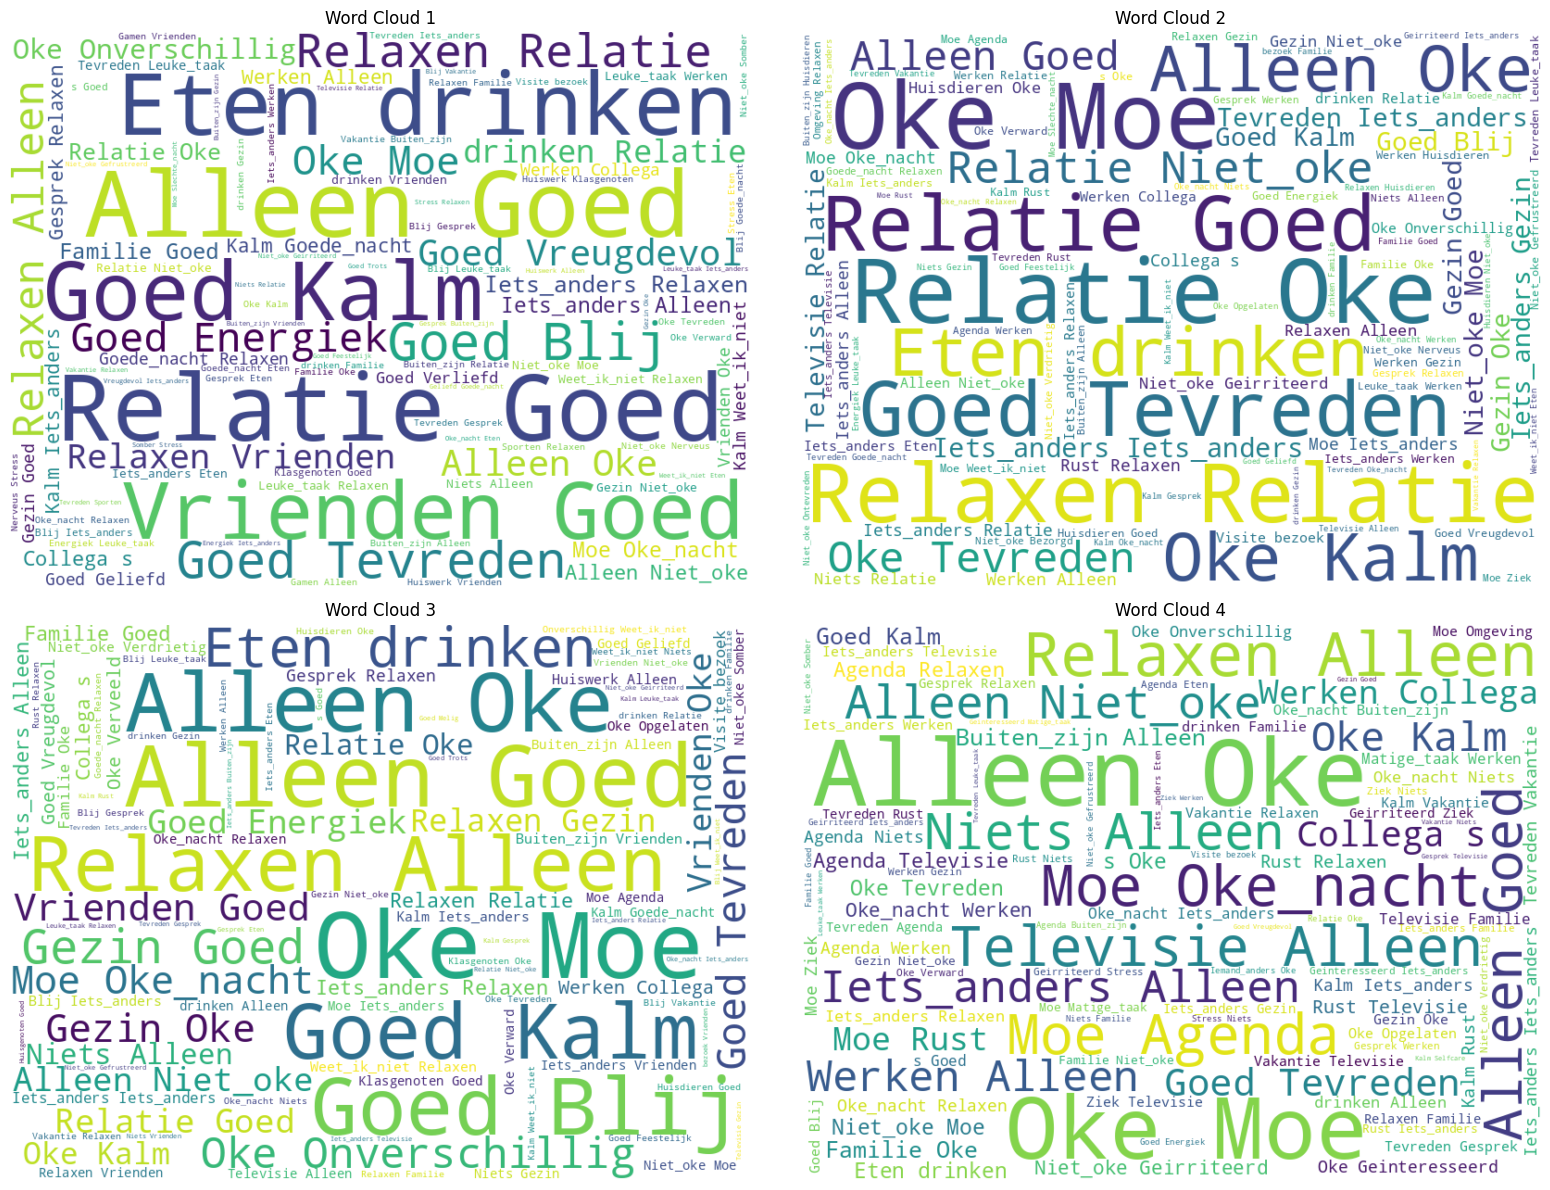

In [ ]:
# it took me 1h12m to execute this code

# tskm, tsdf = tsKmeans(consecutive_days_filtered, num_days)
# print_clouds(tsdf)

In [ ]:
tskm

TimeSeriesKMeans(metric='dtw', n_clusters=20, n_jobs=-1, random_state=0)

In [ ]:
tsdf

,index,user_id,gender,birthday,Date,Time,DateTime,question_1,question_2,question_3,question_4,question_5,response_age,daily_steps,label
0,16162,1004,she,1990.0,2022-06-26,06:01:02,2022-06-26 06:01:02,Goed,Blij,Vakantie,Iets anders,Relatie,32,31806,12
1,16163,1004,she,1990.0,2022-06-27,06:46:17,2022-06-27 06:46:17,Goed,Vreugdevol,Vakantie,Relaxen,Relatie,32,17206,12
2,16166,1004,she,1990.0,2022-06-28,08:29:23,2022-06-28 08:29:23,Goed,Energiek,Vakantie,Visite/bezoek,NaN,32,15715,12
3,16167,1004,she,1990.0,2022-06-29,17:38:33,2022-06-29 17:38:33,Goed,Vreugdevol,Vakantie,Eten/drinken,Relatie,32,6022,12
4,16172,1004,she,1990.0,2022-06-30,17:35:26,2022-06-30 17:35:26,Goed,Kalm,Vakantie,Visite/bezoek,Vrienden,32,-1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72949,59217,10412,he,2006.0,2024-02-24,08:37:45,2024-02-24 08:37:45,Oke,Kalm,Iets anders,Niets,Gezin,18,-1,9
72950,59220,10412,he,2006.0,2024-02-25,19:22:19,2024-02-25 19:22:19,Goed,Kalm,Iets anders,Televisie,Gezin,18,-1,9
72951,59223,10412,he,2006.0,2024-02-26,18:17:44,2024-02-26 18:17:44,Goed,Kalm,Iets anders,Iets anders,Alleen,18,-1,9
72952,59226,10412,he,2006.0,2024-02-27,12:30:36,2024-02-27 12:30:36,Goed,Blij,Iets anders,Niets,Gezin,18,-1,9


<Axes: xlabel='label', ylabel='Count'>

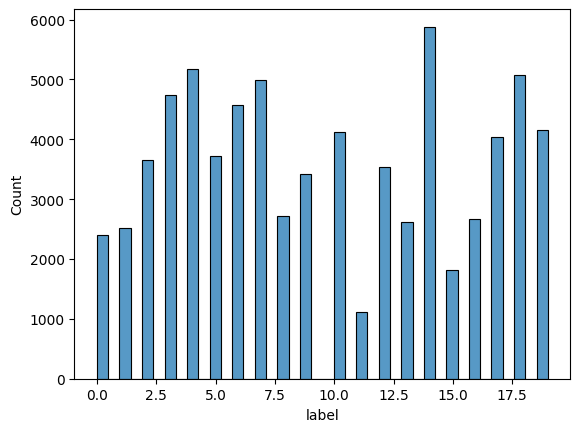

In [ ]:
sns.histplot(tsdf['label'])

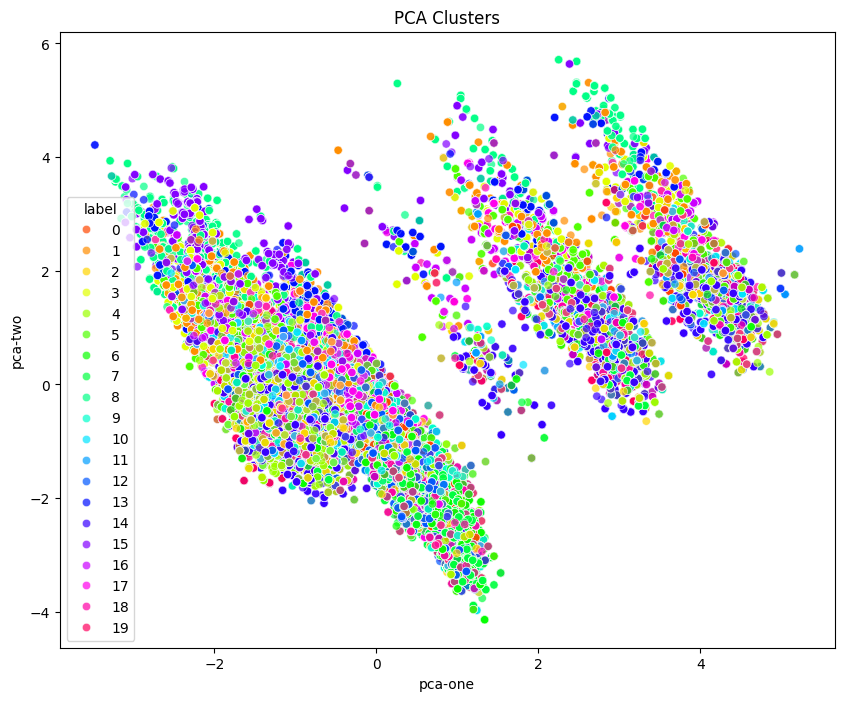

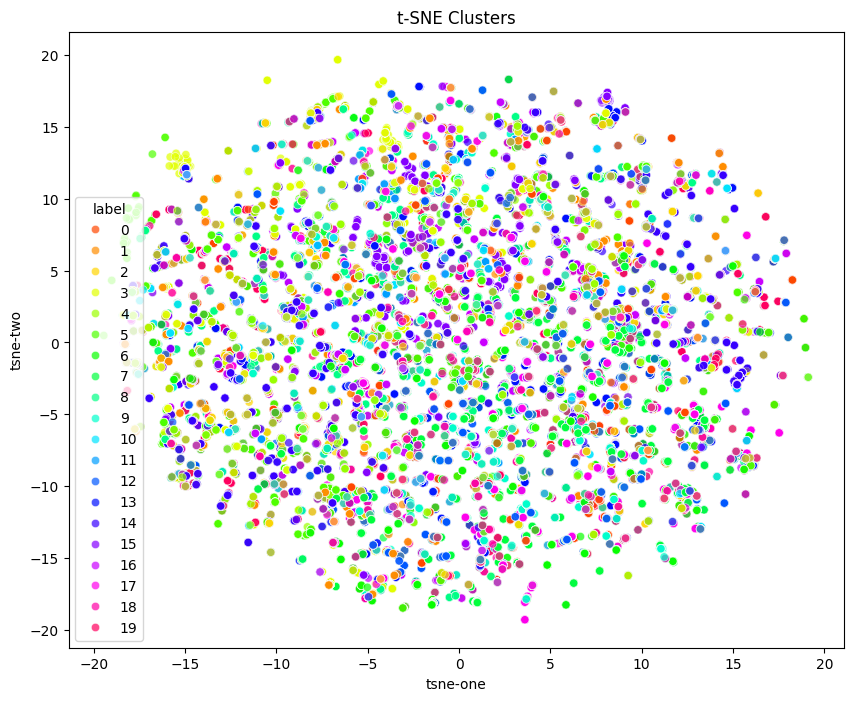

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming tsdf is your dataframe
# Prepare the data
# Convert categorical data to numerical using one-hot encoding
tsdf_encoded = pd.get_dummies(tsdf.drop(columns=['index', 'user_id', 'label', 'Date', 'Time','DateTime' ]), drop_first=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(tsdf_encoded)

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Add PCA results to the dataframe
tsdf['pca-one'] = pca_result[:, 0]
tsdf['pca-two'] = pca_result[:, 1]

# Plotting PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca-one', y='pca-two',
    hue='label',
    palette=sns.color_palette('hsv', len(tsdf['label'].unique())),
    data=tsdf,
    legend="full",
    alpha=0.7
)
plt.title('PCA Clusters')
plt.show()


In [ ]:
# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(scaled_features)

tsdf['tsne-one'] = tsne_results[:, 0]
tsdf['tsne-two'] = tsne_results[:, 1]

# Plotting t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne-one', y='tsne-two',
    hue='label',
    palette=sns.color_palette('hsv', len(tsdf['label'].unique())),
    data=tsdf,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE Clusters')
plt.show()

In [ ]:
tsdf

,index,user_id,gender,birthday,Date,Time,DateTime,question_1,question_2,question_3,question_4,question_5,response_age,daily_steps,label,pca-one,pca-two,tsne-one,tsne-two
0,16162,1004,she,1990.0,2022-06-26,06:01:02,2022-06-26 06:01:02,Goed,Blij,Vakantie,Iets anders,Relatie,32,31806,12,0.501970,-1.068975,-2.061557,-15.720146
1,16163,1004,she,1990.0,2022-06-27,06:46:17,2022-06-27 06:46:17,Goed,Vreugdevol,Vakantie,Relaxen,Relatie,32,17206,12,0.253040,-1.156161,6.508905,-9.089717
2,16166,1004,she,1990.0,2022-06-28,08:29:23,2022-06-28 08:29:23,Goed,Energiek,Vakantie,Visite/bezoek,NaN,32,15715,12,0.318140,-1.408116,-1.841882,-13.383127
3,16167,1004,she,1990.0,2022-06-29,17:38:33,2022-06-29 17:38:33,Goed,Vreugdevol,Vakantie,Eten/drinken,Relatie,32,6022,12,0.338497,-1.262635,6.559662,-9.200766
4,16172,1004,she,1990.0,2022-06-30,17:35:26,2022-06-30 17:35:26,Goed,Kalm,Vakantie,Visite/bezoek,Vrienden,32,-1,12,0.008364,-1.789064,-5.161034,-12.513623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72949,59217,10412,he,2006.0,2024-02-24,08:37:45,2024-02-24 08:37:45,Oke,Kalm,Iets anders,Niets,Gezin,18,-1,9,-0.506152,-0.518921,-4.206469,4.624319
72950,59220,10412,he,2006.0,2024-02-25,19:22:19,2024-02-25 19:22:19,Goed,Kalm,Iets anders,Televisie,Gezin,18,-1,9,0.019317,-0.928219,-2.080010,1.559381
72951,59223,10412,he,2006.0,2024-02-26,18:17:44,2024-02-26 18:17:44,Goed,Kalm,Iets anders,Iets anders,Alleen,18,-1,9,0.112379,-0.607394,-4.861747,7.572259
72952,59226,10412,he,2006.0,2024-02-27,12:30:36,2024-02-27 12:30:36,Goed,Blij,Iets anders,Niets,Gezin,18,-1,9,0.998009,-1.596510,11.230993,-14.937786


In [ ]:
# so I do not have to run the code again, I have created a cvs with the result of the time series clustering
# from google.colab import files
# tsdf.to_csv('time_series_df.csv')
# files.download('time_series_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>